# Create Surface Slabs in HCP Crystals

In this code, a slab for simulating free-surfaces are created. For given Miller indices $(h \, k \, l)$ of the plane, input configuration containing the simulation-cell and atoms is created.

1. Load relevant modules
2. Define necessary parameters
    + Miller indices
    + Lattice (e.g. Aluminum)
    + Cut-off radius (r_cut) and area (a_cut)
3. Compute basis-vectos of the 2D lattice of the $(h \, k \, l)$ plane
4. Compute the basis-vectors of sublattice with r_cut and a_cut constraints
    + Determine appropriate $\Sigma$ using a_cut
    + Generate unique set of sub-lattices (HNF matrices and LLL reduction) 

In [1]:
import byxtal.lattice as gbl
import byxtal.integer_manipulations as iman
import byxtal.bp_basis as bpb
import numpy as np
import numpy.linalg as nla
import math as mt
import gbpy.util_funcs_create_byxtal as uf
import gbpy.generate_hkl_indices as ghi

1. `(h  k  l)` : Miller indices defined in primitive lattice
2. `l1`         : Lattice object
3. `lat_par`    : Lattice parameter
4. `r_cut`      : Cutoff radius
5. `a_cut`      : Cutoff Area
6. `zCut`       : The lenght of the surface-slab is equal to 2(zCut)

In [2]:
l1 = gbl.Lattice('Mg')
h, k, l = 3, 12, 5
hkl_p = np.array([h,k,l])

lat_par = l1.lat_params['a']
r_cut = lat_par*4
a_cut = r_cut**2
zCut = 25*lat_par

1. `l_p_po`   : $\Lambda_{p}^{po}$
2. `l_po_p`   : $\Lambda_{po}^{p}$
3. `l_bpb_p`  : $\Lambda_{\mathrm{2D}}^{p}$
4. `l_bpb_po` : $\Lambda_{\mathrm{2D}}^{po}$

In [3]:
l_p_po = l1.l_p_po
l_po_p = nla.inv(l_p_po)

## l_bpb_p: Primitive Basis vectors of the boundary-plane (in p reference frame)
l_bpb_p = bpb.bp_basis(hkl_p)
l_bpb_p = l_bpb_p.astype(int)
## l_bpb_p: Primitive Basis vectors of the boundary-plane (in po reference frame)
l_bpb_po = l_p_po.dot(l_bpb_p)

1. `sig_num`: $\Sigma$ number
2. `l_bpbSig_p`  : $\Lambda_{\Sigma-\mathrm{2D}}^{p}$
3. `l_bpbSig_po` : $\Lambda_{\Sigma-\mathrm{2D}}^{po}$

In [4]:
## area_bpl: Area of the 2D-primitive-unit-cell
area_bpl = nla.norm((np.cross(l_bpb_po[:,0], l_bpb_po[:,1])))
sig_num = np.ceil(a_cut/area_bpl)

ind2 = np.array([], dtype='int64');
while (np.size(ind2) == 0):
    # Generate 2D hermite normal forms for sig_num (hnf_mats)
    hnf_mats = ghi.sig_hnf_mats(sig_num)
    # Compute the properties of the sub-lattices
    l_sig_p_mats, l_sig_po_mats = ghi.compute_hnf_props(hnf_mats, l_bpb_p, l_p_po, 1e-2)
    # Get the index for the sub-lattice that has the minimum cost
    ind2 = ghi.ind_min_cost(l_sig_po_mats, r_cut)
    sig_num = sig_num + 1

## l_bpbSig_p: Basis vectors of the sub-lattice of the boundary-plane (in p reference frame)
l_bpbSig_p = l_sig_p_mats[ind2];
l_bpbSig_p = l_bpbSig_p.astype(int)
l_bpbSig_po = l_p_po.dot(l_bpbSig_p)

1. `l_po_go`: $\Lambda_{PO}^{GO}$ - Orientation of crystal with respect to global reference frame $\mathrm{GO}$
    + `go`: Orthogonal global reference frame (for LAMMPS)
    + `po`: Orhtogonal reference frame of the lattice
    + function `compute_orientation`: computes the orientation of the crystal such that the basis vectors in $\Lambda_{\Sigma-\mathrm{2D}}^{po}$ are along the x-axis and in the xy-plane.

2. `l2D_bpbSig_go`: $\Lambda_{\Sigma-\mathrm{2D}}^{go}$
3. `l2D_bpb_go`: $\Lambda_{\Sigma-\mathrm{2D}}^{go}$

If computed accurately, the $z$-components of the basis-vectors in the $\mathrm{GO}$ frame, $\Lambda_{\mathrm{2D}}^{go}$ and $\Lambda_{\Sigma-\mathrm{2D}}^{go}$, are zero.

4. `twoD_mat`: The $x$, $y$ components of the 2D basis vectors of $\Lambda_{\mathrm{2D}}^{go}$
5. `twoDSig_mat`: The $x$, $y$ components of the 2D basis vectors of $\Lambda_{\Sigma-\mathrm{2D}}^{go}$
6. `r_cut1`: The cut-off radius for replicating the lattice basis. Given two vectors that form the basis of the interface plane, $\Lambda_{\Sigma-\mathrm{2D}}^{go}$, the function `compute_rCut` determines the maximum of the norms of the two vectors.
7. `twoD_pts`: The lattice points in the 2D periodic box for the 3D slab.

In [5]:
l_po_go = uf.compute_orientation(l_bpbSig_po)
l2D_bpbSig_go = l_po_go.dot(l_bpbSig_po)
l2D_bpb_go = l_po_go.dot(l_bpb_po)
twoD_mat = l2D_bpb_go[:2,:]

twoDSig_mat = l2D_bpbSig_go[:2,:]
r_cut1 = uf.compute_rCut(l_bpbSig_po)

## Create 2D periodic box
twoD_pts = uf.replicate_pts(twoD_mat, r_cut1)
twoD_pts = uf.remove_periodic_overlaps(twoD_pts, twoDSig_mat)

1. `avec`: Basis vector $\vec{a}$ of the 3D lattice defined using $\mathcal{B}_{P2}$.
2. `bvec`: Basis vector $\vec{b}$ of the 3D lattice defined using $\mathcal{B}_{P2}$.
3. `l_p2_p1`: Equivalent basis for the 3D lattice, $\Lambda_{P2}^{P1}$. 
    + The function `find_int_solns` computes the third basis-vector, $\vec{c}$, such that $\mathcal{B}_{P1} \equiv \mathcal{B}_{P2}$

In [6]:
avec = l_bpb_p[:,0]
bvec = l_bpb_p[:,1]
l_p2_p1 = uf.find_int_solns(avec, bvec)

1. `l_p2_po1`: $\Lambda_{p2}^{po1}$
2. `l_p2_go`: $\Lambda_{p2}^{go}$
3. `tz_vec`: The components of $\vec{c}$ of $\mathcal{B}_{P2}$ in $go$ reference frame.
4. `threeD_pts`: The 3D slab of atoms for simulating free surfaces.
    + This is obtained by replicating `twoD_pts` along the `tz_vec` in both +$z$ and -$z$ directions.

In [7]:
l_p2_po1 = l_p_po.dot(l_p2_p1)
l_p2_go = l_po_go.dot(l_p2_po1)
tz_vec = np.array(l_p2_go[:,2], dtype='double')
tz_vec = np.reshape(tz_vec, (3,))

################################################################################
## Translate 2D points in the Z-direction with zCut
num_rep = np.abs(int(np.ceil(zCut/tz_vec[2])))
num_2d = np.shape(twoD_pts)[0]
num_3d_pts = int((2*num_rep+1)*num_2d)
threeD_pts = np.zeros((num_3d_pts,3));

twoD_pts1 = np.hstack((twoD_pts, np.zeros((num_2d,1))));

for ct1 in np.arange(-num_rep, num_rep+1):
    ct2 = ct1 + num_rep
    ind_st = (ct2)*num_2d
    ind_stop = ind_st + num_2d
    trans_vec = tz_vec*ct1
    threeD_pts[ind_st:ind_stop, :] = twoD_pts1 + np.tile(trans_vec, (num_2d,1))

The simulation box vectors are defined using Ovito's convenction.
1. `sim_avec`: The components of $\vec{a}$ in the global reference, $go$, of LAMMPS. $\vec{a}$ is along $\hat{e}_x$.
2. `sim_bvec`: The components of $\vec{b}$ in the global reference, $go$, of LAMMPS. $\vec{b}$ lies in the $x-y$ plane.
3. `sim_cvec`: The components of $\vec{c}$ in the global reference, $go$, of LAMMPS.
4. `sim_orig`: The origin of the simulation box.

In [8]:
### Simulation Cell Box
### Following Ovito's convention
l_bpbSig_po_arr = np.array(l2D_bpbSig_go, dtype='double')
sim_cell = np.zeros((3,4))
sim_avec = l_bpbSig_po_arr[:,0]
sim_bvec = l_bpbSig_po_arr[:,1]

### Change this with inter-planar spacing
sim_cvec = np.array([0,0,2*zCut]); # sim_cvec = np.array([0,0,zCut]);
sim_orig = np.array([0,0,-zCut]); # sim_orig = np.array([0,0,0]);

sim_cell[:,0] = sim_avec
sim_cell[:,1] = sim_bvec
sim_cell[:,2] = sim_cvec
sim_cell[:,3] = sim_orig

box_vecs = sim_cell[:,0:3]



+ HCP crystal structure has two atoms per unit cell which can be defined by:

    l1.basis_atoms = array([[0.        , 0.        , 0.        ],[0.33333333, 0.66666667, 0.5       ]])
       
+ All the calculations applied so far gives the position of atoms at [0,0,0]. We need to add the atoms at the position [1/3, 2/3, 0] to the current atoms using the following steps:
    1. Finding the position of the second atom in the po unit cell.
    2. define the position of the second atom in the go referance frame.
    3. copy and shift all the atoms with the amount found in step 2. 
    4. Combine all the points and delete the overlapping ones.

In [9]:
second_atom = (np.array([l1.lat_params['a']/3, 2*l1.lat_params['a']/3, l1.lat_params['c']/2])).reshape(3,1)
shift = np.dot(l_po_go, second_atom)

shift = shift.reshape(1,3)
th_z = sim_cell[2,2] + sim_cell[2,3]

threeD_pts_1 = threeD_pts + shift
threeD_pts_f = np.append(threeD_pts, threeD_pts_1,axis=0)
threeD_pts_f = threeD_pts_f[threeD_pts_f[:,2] <= th_z]
threeD_pts_f = threeD_pts_f[threeD_pts_f[:,2] >= -th_z]

threeD_pts_final = uf.wrap_cc(sim_cell, threeD_pts_f)

Plot of 3D lattice points along with the simulation box.

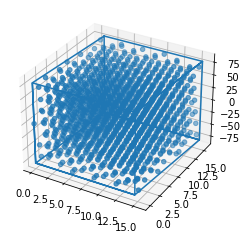

In [10]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import plotting_routines as plr
%matplotlib inline

fig1 = plt.figure()
plr.plot_3d_pts_box(fig1, threeD_pts_final, sim_cell[:,0:3], sim_orig)
plt.show()

Create the lammps dump file in the curretn directory named "hcp.dump"

In [11]:
import lammps_dump as ld
num_atoms = len(threeD_pts_final)
ID = np.arange(num_atoms).reshape(num_atoms, 1) + 1
dump_lamp = np.concatenate((ID, threeD_pts_final), axis=1)
box_bound, box_type = ld.box_bound_func(sim_cell)
ld.write_lammps_dump('./hcp.dump', box_bound, dump_lamp, box_type)